In [1]:
%load_ext autoreload
%autoreload 2

# DENSITY LIMIT ANALYSES

In [2]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rc('axes', axisbelow=True)

plt.rcParams["mathtext.fontset"] = "cm"

import warnings

# Turn off Matplotlib warnings
warnings.filterwarnings("ignore")

import matplotlib.font_manager as fm
from PIL import Image
#import imageio
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from PIL import Image
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

pd.set_option('display.max_columns', None)
#plt.rc('font',family = 'serif')
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["No Spherical"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "Spherical"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

DB5 = tokamakTK.clean_categorical_data(DB5)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
markers = ["o", "v", "^", "<", ">", "P", 9, ".", 
           "8", "s", "p", 11, "*", "h", "H", "X", "D", "d"]
tok_markers = dict(zip(DB5["TOK"].unique(), markers))

In [5]:
def get_HUEORDER(DB5):
    DB5 = tokamakTK.clean_categorical_data(DB5)
    # Needed for Improved Visualization: 2D and 3D Plots
    HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
    hue_order = HUEOrder(HUE_ORDER)

    # ---------------------------------------------------

    # SPECIAL PARAMETERS
    colors_ = sns.color_palette('tab20', 20)
    HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
    HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))
    HUE_ORDER["TOK"]["START"] = (0.8235, 0.5055, 0.4412)
    
    return HUE_ORDER, PX_ORDER

HUE_ORDER, PX_ORDER = get_HUEORDER(DB5)

In [6]:
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [7]:
data2.TOK.unique()

array(['AUG', 'AUGW', 'CMOD', 'COMPASS', 'D3D', 'JET', 'JETILW', 'JFT2M',
       'JT60U', 'MAST', 'NSTX', 'START', 'TCV', 'TDEV', 'TFTR'],
      dtype=object)

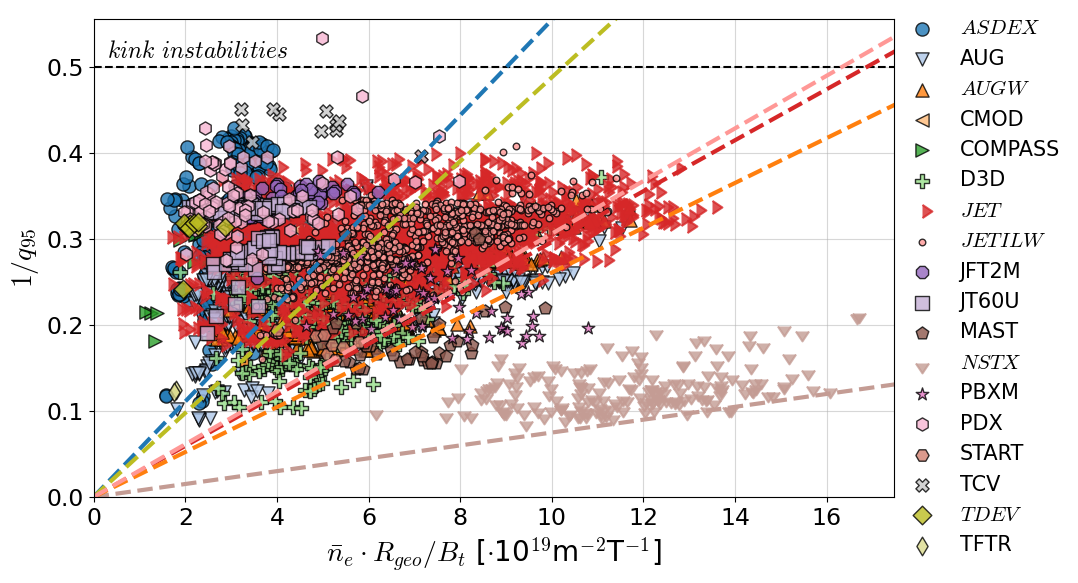

In [8]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(11, 6))

parameter = "TOK"
db5_ = DB5.copy()#[DB5.TOK.isin(["ASDEX","AUG", "JETILW"])].copy()

# Set the parameter and category colors
category_colors = HUE_ORDER[parameter]
xmin, xmax = (0, None)
ymin, ymax = (0, None)
# -------------------------------------

x_label = "$\\bar{n}_e\\cdot R_{geo} / B_t$ [$\\cdot$10$^{19}$m$^{-2}$T$^{-1}$]"
y_label = "$1/q_{95}$"

db5_["Y"] = 1/db5_["Q95"] # Provided by research group
db5_["X"] = db5_["NEL"]*db5_["RGEO"]/np.abs(db5_["BT"])

TOK_lines = ["NSTX","JET","AUGW","ASDEX","TDEV", "JETILW"]
#TOK_lines = ["ASDEX", "AUG","JETILW"]

for tok in db5_["TOK"].unique():
    ax.scatter(db5_[db5_.TOK.isin([tok])]["X"], db5_[db5_.TOK.isin([tok])]["Y"], 
            color=category_colors[tok], edgecolors='black', s=90, alpha=0.8, marker=tok_markers[tok] )

ax.grid(alpha=0.5)

# Add legend outside of the plot
handles = []
labels = []
for tok in db5_["TOK"].unique():
    handle = ax.scatter([], [], color=category_colors[tok], edgecolors='black', alpha=0.8, s=90, marker=tok_markers[tok])
    handles.append(handle)
    if tok in TOK_lines:
        labels.append(r"$\it{" + tok + "}$")  # Bold font for names in TOK_lines
    else:
        labels.append(tok)
ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.23, 1.04), frameon=False, fontsize=15)

ax.set_ylabel(y_label, fontsize=20)
ax.set_xlabel(x_label, fontsize=20)

# LIMITS
# -- Kink instabilities
ax.axhline(y=0.5, color='k', linestyle='--')
ax.text(0.3, 0.51, "$kink$ $instabilities$", fontsize=17, color='black', ha='left')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# -- GreenWald Limit
#for i, tok in enumerate(db5_.TOK.unique()):
for i, tok in enumerate(TOK_lines):
    db5_["GW_limit"] = (10*np.abs(db5_["IP"]))/(np.pi*db5_["AMIN"]*db5_["AMIN"])
    GW_lims = db5_[db5_.TOK.isin([tok])]
    GW_lims = GW_lims[GW_lims.GW_limit.isin([max(
                        GW_lims["GW_limit"])])][["Y","GW_limit","BT", "Q95","RGEO","TOK"]]
    m = (GW_lims["GW_limit"]*GW_lims["RGEO"]*GW_lims["Q95"]/np.abs(GW_lims["BT"])).values[0]
    x = np.linspace(0,max(db5_["X"]*1.1))
    ax.plot(x, (m**-1)*x, color=category_colors[tok], linestyle="--", linewidth=3)

ax.tick_params(axis='both', which='major', labelsize=17)

# Adjust the spacing between subplots
#plt.savefig(fig_path+"DensityStability_STDB5.pdf", format="pdf", dpi=800, bbox_inches='tight');
plt.tight_layout()

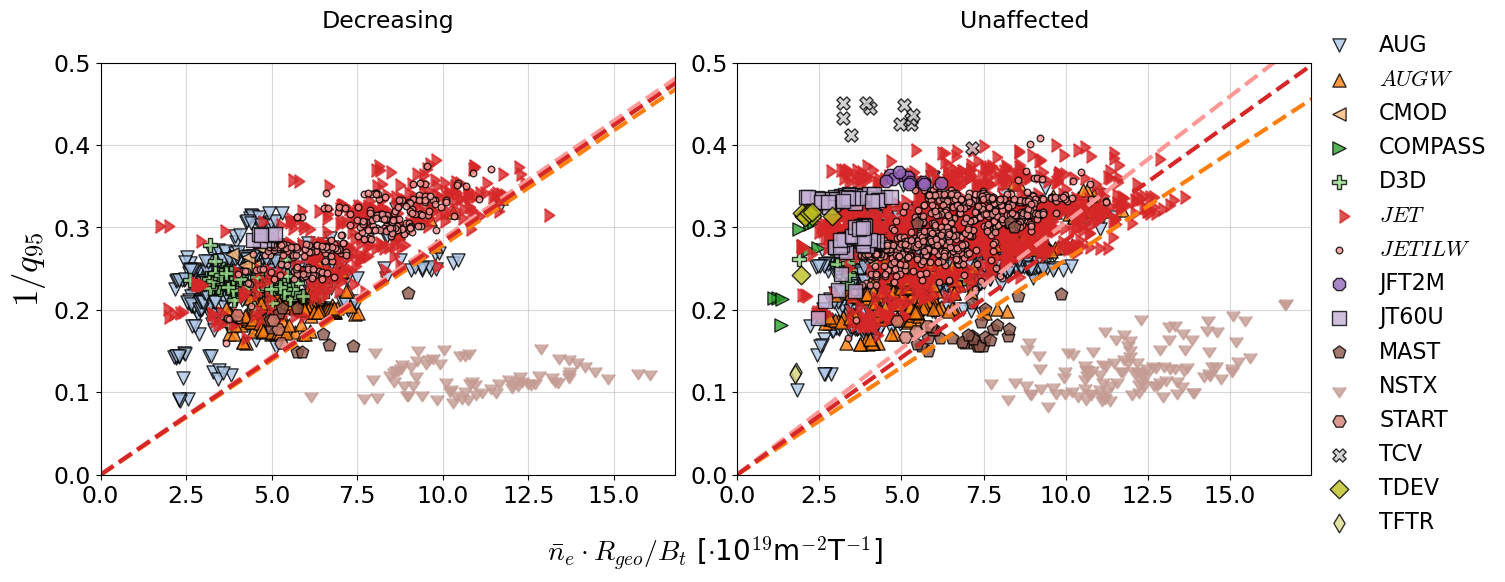

In [9]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5.5))


import pdb # For debugging || pdb.set_trace()

parameter = "TOK"
db5_ = DB5.copy()#[DB5.TOK.isin(["ASDEX","AUG", "JETILW"])].copy()

# Set the parameter and category colors
category_colors = HUE_ORDER[parameter]
xmin, xmax = (0, None)
ymin, ymax = (0, 0.5)
# -------------------------------------

x_label = "$\\bar{n}_e\\cdot R_{geo} / B_t$ [$\\cdot$10$^{19}$m$^{-2}$T$^{-1}$]"
y_label = "$1/q_{95}$"

data1["Y"] = 1/data1["Q95"] 
data2["Y"] = 1/data2["Q95"] 

data1["X"] = data1["NEL"]*data1["RGEO"]/np.abs(data1["BT"])
data2["X"] = data2["NEL"]*data2["RGEO"]/np.abs(data2["BT"])

TOK_lines = ["AUGW","JETILW","JET"]

for tok in data1["TOK"].unique():
    ax1.scatter(data1[data1.TOK.isin([tok])]["X"], data1[data1.TOK.isin([tok])]["Y"], 
            color=category_colors[tok], edgecolors='black', s=90, alpha=0.8, marker=tok_markers[tok] )
ax1.grid(alpha=0.5)

for tok in data2["TOK"].unique():
    ax2.scatter(data2[data2.TOK.isin([tok])]["X"], data2[data2.TOK.isin([tok])]["Y"], 
            color=category_colors[tok], edgecolors='black', s=90, alpha=0.8, marker=tok_markers[tok] )
ax2.grid(alpha=0.5)

# Add legend outside of the plot
handles = []
labels = []
for tok in data2["TOK"].unique():
    handle = ax2.scatter([], [], color=category_colors[tok], edgecolors='black', alpha=0.8, s=90, marker=tok_markers[tok])
    handles.append(handle)
    if tok in TOK_lines:
        labels.append(r"$\it{" + tok + "}$")  # Bold font for names in TOK_lines
    else:
        labels.append(tok)
ax2.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.34, 1.12), frameon=False, fontsize=16)

ax1.set_ylabel(y_label, fontsize=25)
fig.text(0.48, -0.03, x_label, ha='center', fontsize=20)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

ax1.set_title("Decreasing\n", fontsize=17)
ax2.set_title("Unaffected\n", fontsize=17)

ax1.tick_params(axis='both', which='major', labelsize=17)
ax2.tick_params(axis='both', which='major', labelsize=17)

# -- GreenWald Limit

for i, tok in enumerate(TOK_lines):
    data2["GW_limit"] = (10*np.abs(data2["IP"]))/(np.pi*data2["AMIN"]*data2["AMIN"])
    GW_lims = data2[data2.TOK.isin([tok])]
    GW_lims = GW_lims[GW_lims.GW_limit.isin([max(
                        GW_lims["GW_limit"])])][["Y","GW_limit","BT", "Q95","RGEO","TOK"]]
    m = (GW_lims["GW_limit"]*GW_lims["RGEO"]*GW_lims["Q95"]/np.abs(GW_lims["BT"])).values[0]
    x = np.linspace(0,max(data2["X"]*1.1))
    ax2.plot(x, (m**-1)*x, color=category_colors[tok], linestyle="--", linewidth=3)
    
for i, tok in enumerate(TOK_lines):
    data1["GW_limit"] = (10*np.abs(data1["IP"]))/(np.pi*data1["AMIN"]*data1["AMIN"])
    GW_lims = data1[data1.TOK.isin([tok])]
    GW_lims = GW_lims[GW_lims.GW_limit.isin([max(
                        GW_lims["GW_limit"])])][["Y","GW_limit","BT", "Q95","RGEO","TOK"]]
    m = (GW_lims["GW_limit"]*GW_lims["RGEO"]*GW_lims["Q95"]/np.abs(GW_lims["BT"])).values[0]
    x = np.linspace(0,max(data1["X"]*1.1))
    ax1.plot(x, (m**-1)*x, color=category_colors[tok], linestyle="--", linewidth=3)


# Adjust the spacing between subplots
plt.tight_layout()
#plt.savefig(fig_path+"comparative_DensityStability_DU.pdf", format="pdf", dpi=800, bbox_inches='tight');